<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/itkimage2segimageAndRadiomicsNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook does the last step in the split workflow on Terra**

The NIFTI files generated from Totalsegmentator are provided as input and the DICOM files are downloaded again to generate DICOM SEG Objects

Please cite:
Herz C, Fillion-Robin JC, Onken M, Riesmeier J, Lasso A, Pinter C, Fichtinger G, Pieper S, Clunie D, Kikinis R, Fedorov A. dcmqi: An Open Source Library for Standardized Communication of Quantitative Image Analysis Results Using DICOM. Cancer Res. 2017 Nov 1;77(21):e87-e90. doi: 10.1158/0008-5472.CAN-17-0336. PMID: 29092948; PMCID: PMC5675033.

###**Installing Packages**

In [1]:
%%capture
#Installing lz4 for compression/decompression
#xvfb required for previewing Totalsegmentator png images
!apt-get install lz4 dcm2niix wget pigz

In [2]:
%%capture
!pip install pyradiomics nibabel p_tqdm tqdm

In [3]:
%%capture
dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz"
dcmqi_download_path = f"dcmqi-1.2.5-linux.tar.gz"
dcmqi_path = f"dcmqi-1.2.5-linux"

!wget -O $dcmqi_download_path $dcmqi_release_url

!tar -xvf $dcmqi_download_path 

!mv $dcmqi_path/bin/* /bin
!rm -r $dcmqi_download_path $dcmqi_path

In [4]:
%%capture
#install s5cmd
!wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
!tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
!rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
!mv s5cmd /usr/local/bin/s5cmd
!rm CHANGELOG.md LICENSE README.md

###**Importing Packages**

In [10]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
from functools import partial
import glob
import json
import logging
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
from pathlib import Path
import pandas as pd
import psutil
import radiomics
from radiomics import featureextractor
import shutil
import SimpleITK as sitk
import sys
from time import sleep
import time
import tqdm
from tqdm.contrib.concurrent import process_map


logging.getLogger('pyradiomics').setLevel(logging.CRITICAL)

curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Fri May  5 19:23:03 2023

Current directory :/content
Python version    : 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


###**Parameters for Papermill**

In [11]:
csvFilePath=''
inferenceNiftiFilePath=''
converterType='dcm2niix'

###**For local testing**

In [12]:
try:
  os.remove(f'{curr_dir}/batch_1.csv')
  os.remove(f'{curr_dir}/inferenceNiftiFiles.tar.lz4')
except OSError:
  pass

!wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
csvFilePath = glob.glob('*.csv')[0]

!wget https://github.com/vkt1414/Cloud-Resources-Workflows/raw/main/sampleManifests/inferenceNiftiFiles.tar.lz4
#Get the file path of the inferenceNiftiFiles
inferenceNiftiFilePath=glob.glob('*.lz4')[0]

--2023-05-05 19:23:03--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139861 (137K) [text/plain]
Saving to: ‘batch_1.csv’

batch_1.csv         100%[===================>] 136.58K  --.-KB/s    in 0.02s   

2023-05-05 19:23:03 (6.04 MB/s) - ‘batch_1.csv’ saved [139861/139861]

--2023-05-05 19:23:03--  https://github.com/vkt1414/Cloud-Resources-Workflows/raw/main/sampleManifests/inferenceNiftiFiles.tar.lz4
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampl

###Extracting Inference NIFTI files

In [13]:
try:
  shutil.rmtree(f'Inference')
except OSError:
  pass
#!lz4 -d --rm {inferenceNiftiFilePath} -c | tar --strip-components=0 -xvf -

!lz4 -d --rm {inferenceNiftiFilePath} -c | tar --strip-components=0 -xvf - 
#!rm -r Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/ 

Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345/
Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/
Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.nii.lz4
Inference/1.2.840.113654.2.55.142419057730651121165090739113900499978/
Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/
Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215.nii.lz4
Inference/1.2.840.113654.2.55.185309182591805634517860395342326800332/
Inference/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033.ni

###Reading CSV File containing s5cmd Urls

In [14]:
start_time = time.time()
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')  

read in 0.016525983810424805  seconds


###**Downloading Config for DICOM_SEG conversion and Label maps from TotalSegmentator** 

In [15]:
try:
  os.remove(f'{curr_dir}/dicomseg_metadata_whole_slicerAsRef.json')
  os.remove(f'{curr_dir}/map_to_binary.py')
except OSError:
  pass
!wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
!wget https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/totalsegmentator/map_to_binary.py
import map_to_binary

--2023-05-05 19:23:05--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76948 (75K) [text/plain]
Saving to: ‘dicomseg_metadata_whole_slicerAsRef.json’

dicomseg_metadata_w 100%[===================>]  75.14K  --.-KB/s    in 0.01s   

2023-05-05 19:23:05 (5.99 MB/s) - ‘dicomseg_metadata_whole_slicerAsRef.json’ saved [76948/76948]

--2023-05-05 19:23:05--  https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/totalsegmentator/map_to_binary.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.gith

###Functions

In [16]:
try:
  shutil.rmtree(f'itkimage2segimage')
  shutil.rmtree(f'radiomics')
  shutil.rmtree(f'{converterType}')
except OSError:
  pass
os.mkdir(f'itkimage2segimage')
os.mkdir(f'radiomics')
os.mkdir(f'{converterType}')

In [17]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.

  """
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [18]:
def convert_dicom_to_nifti(series_id):
  
  if converterType.lower()=='dcm2niix':
    try:
      shutil.rmtree(f'dcm2niix/{series_id}')
    except OSError:
      pass
    os.mkdir(f'dcm2niix/{series_id}')

    !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  else:
    try:
      shutil.rmtree(f'plastimatch/{series_id}')
    except OSError:
      pass
    os.mkdir(f'plastimatch/{series_id}')
    """
    Make sure to check the s5cmd urls for the destination directory and 
    plastimatch input directory must be changed accordingly
    dcm2niix, however, checks upto depth 5 to find DICOM files

    """
    !plastimatch convert --input /{curr_dir}/idc_data/{series_id} --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz


In [19]:
#set radiomics verbosity
logger = radiomics.logger
logger.setLevel(logging.WARNING) 

In [20]:
def get_radiomics_features(seg_file, img_file, label=None):
    try:
      standard_features = ['shape_Elongation', 'shape_Flatness', 'shape_LeastAxisLength', 'shape_MajorAxisLength', 'shape_Maximum2DDiameterColumn', 'shape_Maximum2DDiameterRow', 'shape_Maximum2DDiameterSlice', 'shape_Maximum3DDiameter', 'shape_MeshVolume', 'shape_MinorAxisLength', 'shape_Sphericity', 'shape_SurfaceArea', 'shape_SurfaceVolumeRatio', 'shape_VoxelVolume', 'firstorder_10Percentile', 'firstorder_90Percentile', 'firstorder_Energy', 'firstorder_Entropy', 'firstorder_InterquartileRange', 'firstorder_Kurtosis', 'firstorder_Maximum', 'firstorder_MeanAbsoluteDeviation', 'firstorder_Mean', 'firstorder_Median', 'firstorder_Minimum', 'firstorder_Range', 'firstorder_RobustMeanAbsoluteDeviation', 'firstorder_RootMeanSquared', 'firstorder_Skewness', 'firstorder_TotalEnergy', 'firstorder_Uniformity', 'firstorder_Variance', 'glcm_Autocorrelation', 'glcm_ClusterProminence', 'glcm_ClusterShade', 'glcm_ClusterTendency', 'glcm_Contrast', 'glcm_Correlation', 'glcm_DifferenceAverage', 'glcm_DifferenceEntropy', 'glcm_DifferenceVariance', 'glcm_Id', 'glcm_Idm', 'glcm_Idmn', 'glcm_Idn', 'glcm_Imc1', 'glcm_Imc2', 'glcm_InverseVariance', 'glcm_JointAverage', 'glcm_JointEnergy', 'glcm_JointEntropy', 'glcm_MCC', 'glcm_MaximumProbability', 'glcm_SumAverage', 'glcm_SumEntropy', 'glcm_SumSquares', 'gldm_DependenceEntropy', 'gldm_DependenceNonUniformity', 'gldm_DependenceNonUniformityNormalized', 'gldm_DependenceVariance', 'gldm_GrayLevelNonUniformity', 'gldm_GrayLevelVariance', 'gldm_HighGrayLevelEmphasis', 'gldm_LargeDependenceEmphasis', 'gldm_LargeDependenceHighGrayLevelEmphasis', 'gldm_LargeDependenceLowGrayLevelEmphasis', 'gldm_LowGrayLevelEmphasis', 'gldm_SmallDependenceEmphasis', 'gldm_SmallDependenceHighGrayLevelEmphasis', 'gldm_SmallDependenceLowGrayLevelEmphasis', 'glrlm_GrayLevelNonUniformity', 'glrlm_GrayLevelNonUniformityNormalized', 'glrlm_GrayLevelVariance', 'glrlm_HighGrayLevelRunEmphasis', 'glrlm_LongRunEmphasis', 'glrlm_LongRunHighGrayLevelEmphasis', 'glrlm_LongRunLowGrayLevelEmphasis', 'glrlm_LowGrayLevelRunEmphasis', 'glrlm_RunEntropy', 'glrlm_RunLengthNonUniformity', 'glrlm_RunLengthNonUniformityNormalized', 'glrlm_RunPercentage', 'glrlm_RunVariance', 'glrlm_ShortRunEmphasis', 'glrlm_ShortRunHighGrayLevelEmphasis', 'glrlm_ShortRunLowGrayLevelEmphasis', 'glszm_GrayLevelNonUniformity', 'glszm_GrayLevelNonUniformityNormalized', 'glszm_GrayLevelVariance', 'glszm_HighGrayLevelZoneEmphasis', 'glszm_LargeAreaEmphasis', 'glszm_LargeAreaHighGrayLevelEmphasis', 'glszm_LargeAreaLowGrayLevelEmphasis', 'glszm_LowGrayLevelZoneEmphasis', 'glszm_SizeZoneNonUniformity', 'glszm_SizeZoneNonUniformityNormalized', 'glszm_SmallAreaEmphasis', 'glszm_SmallAreaHighGrayLevelEmphasis', 'glszm_SmallAreaLowGrayLevelEmphasis', 'glszm_ZoneEntropy', 'glszm_ZonePercentage', 'glszm_ZoneVariance', 'ngtdm_Busyness', 'ngtdm_Coarseness', 'ngtdm_Complexity', 'ngtdm_Contrast', 'ngtdm_Strength']
      settings = {}
      settings["resampledPixelSpacing"] = [3,3,3]
      settings["geometryTolerance"] = 1e-3
      settings["featureClass"] = ["shape"]
      radiomics.setVerbosity(logging.CRITICAL)
      extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
      extractor.disableAllFeatures()
      extractor.enableFeatureClassByName("shape")
      extractor.enableFeatureClassByName("firstorder")
      features = extractor.execute(str(img_file), str(seg_file), label=label)
      features = {k.replace("original_", ""): v for k, v in features.items() if k.startswith("original_")}
      features = {k: round(float(v), 4) for k, v in features.items()}
    except Exception as e:
      print(f"WARNING: radiomics raised an exception (settings all features to 0): {e}")
      features = {feat: 0 for feat in standard_features}

    return label, features

In [21]:
# from tqdm import tqdm
# import multiprocessing
# from functools import partial

# def process_mask(seg_file, ct_file, label_id_body_part_df, label):
#     mask_name, mask_stats = get_radiomics_features(seg_file, ct_file, label=label)
#     mask_stats = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in mask_stats.items()}
#     body_part = label_id_body_part_df.loc[label_id_body_part_df['label_id'] == label]['body_part'].values[0]
#     return (body_part, mask_stats)

# def get_radiomics_features_for_all_labels(ct_file: Path, seg_file: Path, file_out: Path):
#     label_id_body_part_data = map_to_binary.class_map['total'].items()
#     # create a DataFrame from the extracted data
#     label_id_body_part_df = pd.DataFrame(label_id_body_part_data, columns=['label_id', 'body_part'])
#     stats = {}
#     labels = [int(x) for x in np.unique(nib.load(seg_file).get_fdata()).tolist() if x != 0]
#     with multiprocessing.Pool() as pool:
#         func = partial(process_mask, seg_file, ct_file, label_id_body_part_df)
#         results = list(tqdm(pool.imap(func, labels), total=len(labels)))
#     for body_part, mask_stats in results:
#         stats[body_part] = mask_stats
#     with open(file_out, "w") as f:
#         json.dump(stats, f, indent=4)

In [22]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
def process_mask(seg_file, ct_file, label_id_body_part_df, label):
    mask_name, mask_stats = get_radiomics_features(seg_file, ct_file, label=label)
    mask_stats = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in mask_stats.items()}
    body_part = label_id_body_part_df.loc[label_id_body_part_df['label_id'] == label]['body_part'].values[0]
    return (body_part, mask_stats)

def get_radiomics_features_for_all_labels(ct_file: Path, seg_file: Path, file_out: Path):
    label_id_body_part_data = map_to_binary.class_map['total'].items()
    # create a DataFrame from the extracted data
    label_id_body_part_df = pd.DataFrame(label_id_body_part_data, columns=['label_id', 'body_part'])
    stats = {}
    labels = [int(x) for x in np.unique(nib.load(seg_file).get_fdata()).tolist() if x != 0]
    with ThreadPoolExecutor() as executor:
        func = partial(process_mask, seg_file, ct_file, label_id_body_part_df)
        results = list(tqdm(executor.map(func, labels), total=len(labels)))
    for body_part, mask_stats in results:
        stats[body_part] = mask_stats
    with open(file_out, "w") as f:
        json.dump(stats, f, indent=4)

In [23]:
def remove_directories_without_nii_files(path):
    for dirpath, dirnames, filenames in os.walk(path, topdown=False):
        if dirpath != path and not any(filename.endswith('.nii.lz4') for filename in filenames):
            try:
                os.rmdir(dirpath)
            except OSError as e:
                print(f"Error: Failed to remove directory {dirpath}: {e}")

In [24]:
#removing empty directories
remove_directories_without_nii_files(os.path.join(curr_dir,'Inference/'))

In [25]:
def check_itkimage_errors(series_id):
    try:
        # Check if the output file from itkimage2segimage exists
        assert os.path.exists(f"{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm")
    except AssertionError:
        # If the output file does not exist, log an error
        with open('itkimage2segimage_error_file.txt', 'a') as f:
            f.write(f"Error: itkimage2segimage failed for series {series_id}\n")
        return True
    return False

In [26]:
def check_radiomics_errors(series_id):
    try:
        # Check if the output file from itkimage2segimage exists
        assert os.path.exists(f"{curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json")
    except AssertionError:
        # If the output file does not exist, log an error
        with open('radiomics_error_file.txt', 'a') as f:
            f.write(f"Error: Radiomics Feature extraction failed for series {series_id}\n")
        return True
    return False

In [27]:
def itkimage2segimageAndRadiomics(series_id):
      try:
        shutil.rmtree(f'itkimage2segimage/{series_id}')
        shutil.rmtree(f'radiomics/{series_id}')
      except OSError:
        pass
        os.mkdir(f'itkimage2segimage/{series_id}')
        os.mkdir(f'radiomics/{series_id}')

      print("Processing series: "+series_id)  

      """
      Downloading DICOM files only for the Series with Totalsegmentator NIFTI files

      """
      download_dicom_data(series_id) 
      convert_dicom_to_nifti(series_id)

      #Get Inference NIFTI file path
      inference_nifti_filename_path = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii.lz4')
      inference_nifti_filename = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii')
      
      try:
        os.remove(inference_nifti_filename)
      except OSError:
        pass
      !lz4 -d {inference_nifti_filename_path}
      #remove the compressed file after decompressing
      !rm -r {inference_nifti_filename_path}
       
      start_time = time.time()
      !itkimage2segimage --inputImageList {inference_nifti_filename} --inputDICOMDirectory {curr_dir}/idc_data/ --outputDICOM {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm --inputMetadata {curr_dir}/dicomseg_metadata_whole_slicerAsRef.json --skip >> /dev/null
      itkimage2segimage_time = time.time() - start_time
      print("Done in %g seconds."%itkimage2segimage_time)
      
      check_itkimage_errors(series_id)


      ct_series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      ct_nifti_files = os.listdir(ct_series_id_folder_path)
      # Get the first (and only) file in the list
      ct_nifti_filename = ct_nifti_files[0]
      # Get the full path of the file
      ct_nifti_filename_path = os.path.join(ct_series_id_folder_path, ct_nifti_filename)
      
      radiomics_output_filename= os.path.join(curr_dir, 'radiomics', series_id, f'{series_id}_radiomics.json')
      
      start_time = time.time()   
      get_radiomics_features_for_all_labels(ct_nifti_filename_path, inference_nifti_filename, radiomics_output_filename)
      radiomics_time = time.time() - start_time
      print("Radiomics Features Calculation Done in %g seconds."%radiomics_time)
      

      check_radiomics_errors(series_id)


      start_time = time.time()     
      !lz4 --rm {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm  {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm.lz4
      !lz4 --rm {curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json  {curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json.lz4
      archiving_time = time.time() - start_time
      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      log['itkimage2segimage_time']=itkimage2segimage_time
      log['archiving_time'] = archiving_time
      log['radiomics_time']= radiomics_time

      !rm -r {curr_dir}/Inference/{series_id}
      !rm -r {curr_dir}/idc_data
      !rm -r {curr_dir}/{converterType}/{series_id}

      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [28]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb,  disk_usage_all, disk_total

###Convert Inference NIFTI file to DICOM_SEG Object

Processing series: 1.2.840.113654.2.55.100875189782210690344207306235124901243
Copying files from IDC buckets..
Done in 1.22511 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 135 DICOM file(s)
Convert 135 DICOM as //content/dcm2niix/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243_0_OPA_GE_LSQX_STANDARD_360_2.5_120_na_na_na_19990102000000_2 (512x512x135x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243_0_OPA_GE_LSQX_STANDARD_360_2.5_120_na_na_na_19990102000000_2.nii"
Conversion required 4.717840 seconds (0.316282 for core code).
Decoding file /content/Inference/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243.nii 
/content/Inference/1 : decoded 35401152 bytes 
Done in

100%|██████████| 76/76 [10:53<00:00,  8.59s/it]

Radiomics Features Calculation Done in 655.431 seconds.
Compressed 93066298 bytes into 768880 bytes ==> 0.83%


Compressed 106546 bytes into 31306 bytes ==> 29.38%


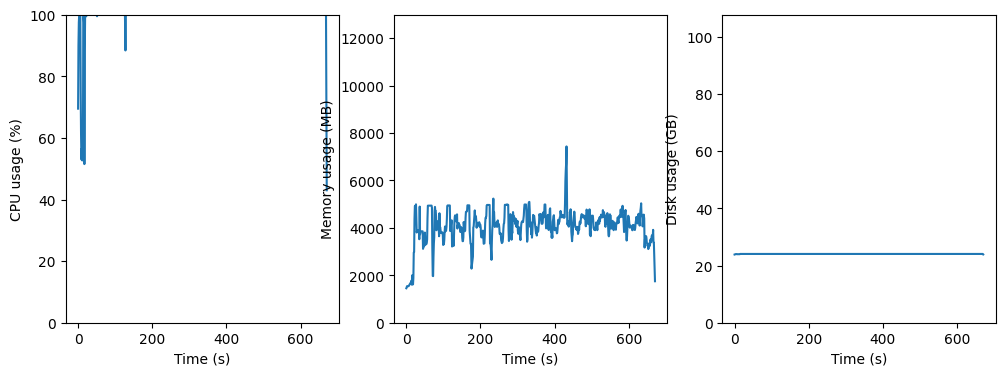

Processing series: 1.2.840.113654.2.55.14382674871619950799472325766084940706
Copying files from IDC buckets..
Done in 0.807926 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 122 DICOM file(s)
Convert 122 DICOM as //content/dcm2niix/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706_0_OPA_GE_LSQX_STANDARD_350_2.5_120_na_na_na_19990102000000_2 (512x512x122x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706_0_OPA_GE_LSQX_STANDARD_350_2.5_120_na_na_na_19990102000000_2.nii"
Conversion required 4.658583 seconds (0.292965 for core code).
Decoding file /content/Inference/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706.nii 
/content/Inference/1 : decoded 31993280 bytes 
Done in 7.054

100%|██████████| 75/75 [09:16<00:00,  7.42s/it]

Radiomics Features Calculation Done in 558.881 seconds.
Compressed 80965748 bytes into 678512 bytes ==> 0.84%


Compressed 107833 bytes into 31401 bytes ==> 29.12%


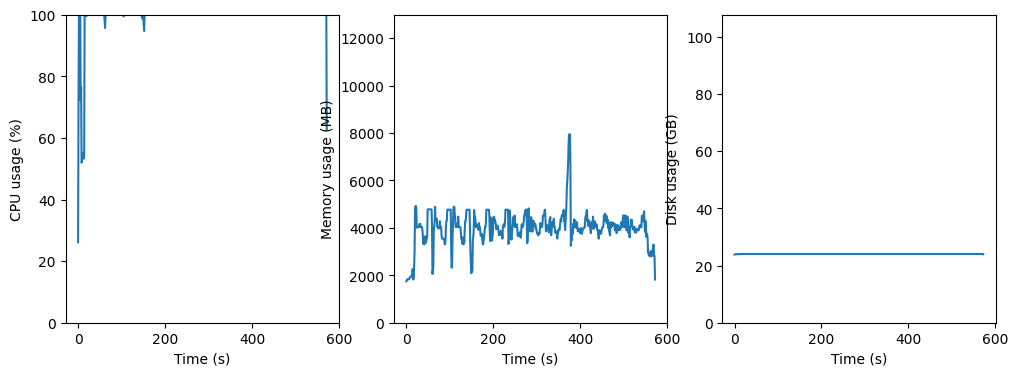

Processing series: 1.2.840.113654.2.55.216614002338888733987350522981366678482
Copying files from IDC buckets..
Done in 0.607036 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 130 DICOM file(s)
Convert 130 DICOM as //content/dcm2niix/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482_0_OPA_GE_HSQX_BONE_340_2.5_120_56_0.1_1.5_19990102000000_3 (512x512x130x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482_0_OPA_GE_HSQX_BONE_340_2.5_120_56_0.1_1.5_19990102000000_3.nii"
Conversion required 3.728463 seconds (0.262231 for core code).
Decoding file /content/Inference/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482.nii 
/content/Inference/1 : decoded 34090432 bytes 
Done in 9.

100%|██████████| 76/76 [09:58<00:00,  7.88s/it]

Radiomics Features Calculation Done in 601.541 seconds.
Compressed 87966362 bytes into 731131 bytes ==> 0.83%


Compressed 106702 bytes into 31267 bytes ==> 29.30%


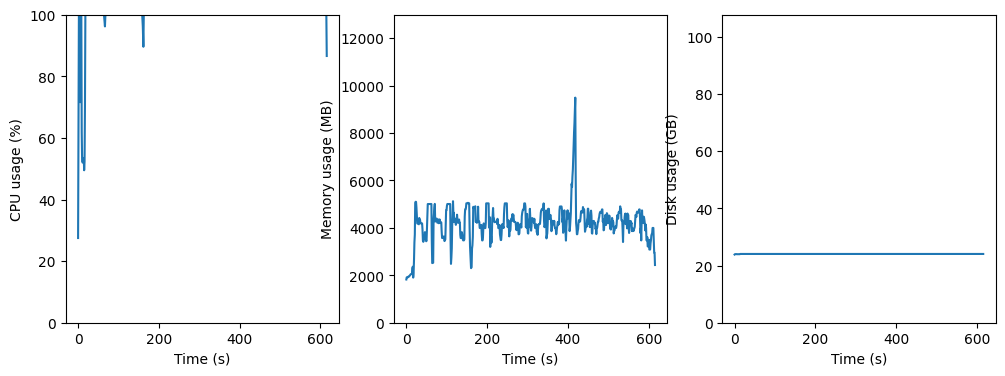

Processing series: 1.2.840.113654.2.55.146601594654322994982630019583270053397
Copying files from IDC buckets..
Done in 0.807848 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 139 DICOM file(s)
Convert 139 DICOM as //content/dcm2niix/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397_1_OPA_GE_LSQX_STANDARD_360_2.5_140_40_0_1.5_20000102000000_2 (512x512x139x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397_1_OPA_GE_LSQX_STANDARD_360_2.5_140_40_0_1.5_20000102000000_2.nii"
Conversion required 4.272373 seconds (0.282314 for core code).
Decoding file /content/Inference/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397.nii 
/content/Inference/1 : decoded 36449728 bytes 
Done i

 41%|████      | 32/78 [04:49<06:14,  8.15s/it]

 95%|█████████▍| 74/78 [10:31<00:40, 10.05s/it]

100%|██████████| 78/78 [10:34<00:00,  8.13s/it]

Radiomics Features Calculation Done in 636.969 seconds.
Compressed 96367168 bytes into 767785 bytes ==> 0.80%


Compressed 114719 bytes into 32601 bytes ==> 28.42%


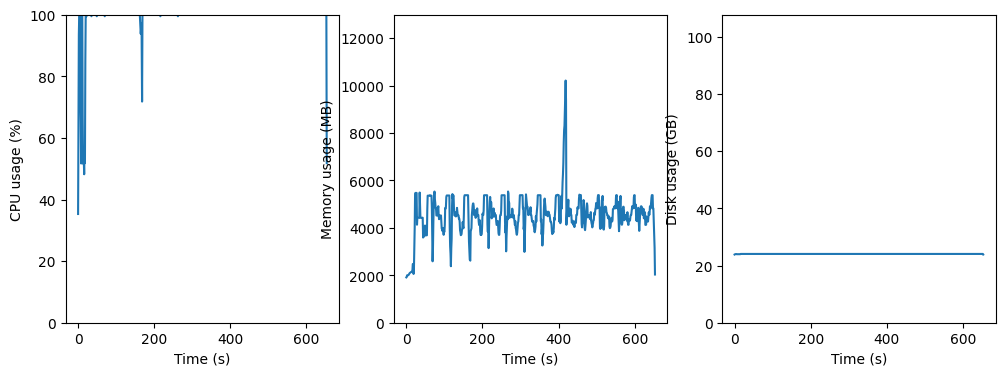

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033
Copying files from IDC buckets..
Done in 0.811036 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 115 DICOM file(s)
Convert 115 DICOM as //content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2 (512x512x115x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.43137777340119792448555100603_1_OPA_GE_LS16_STANDARD_339_2.5_120_40_29.1_1.4_20000102000000_2.nii"
Conversion required 5.426550 seconds (0.233893 for core code).
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033.nii 
/content/Infer

100%|██████████| 72/72 [08:23<00:00,  6.99s/it]

Radiomics Features Calculation Done in 505.438 seconds.
Compressed 82932568 bytes into 645428 bytes ==> 0.78%


Compressed 100932 bytes into 29776 bytes ==> 29.50%


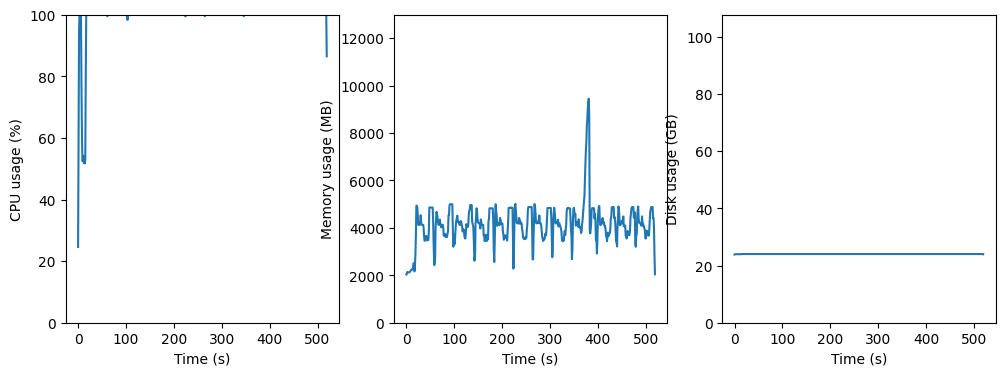

Processing series: 1.2.840.113654.2.55.154809705591242159075253605419469935510
Copying files from IDC buckets..
Done in 1.51245 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 112 DICOM file(s)
Convert 112 DICOM as //content/dcm2niix/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510_0_OPA_GE_LSQX_STANDARD_310_2.5_120_64_0.1_1.5_19990102000000_2 (512x512x112x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510_0_OPA_GE_LSQX_STANDARD_310_2.5_120_64_0.1_1.5_19990102000000_2.nii"
Conversion required 3.251805 seconds (0.249335 for core code).
Decoding file /content/Inference/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510.nii 
/content/Inference/1 : decoded 29371840 bytes 
Don

100%|██████████| 74/74 [08:08<00:00,  6.60s/it]

Radiomics Features Calculation Done in 490.377 seconds.
Compressed 71332314 bytes into 564984 bytes ==> 0.79%


Compressed 103579 bytes into 30488 bytes ==> 29.43%


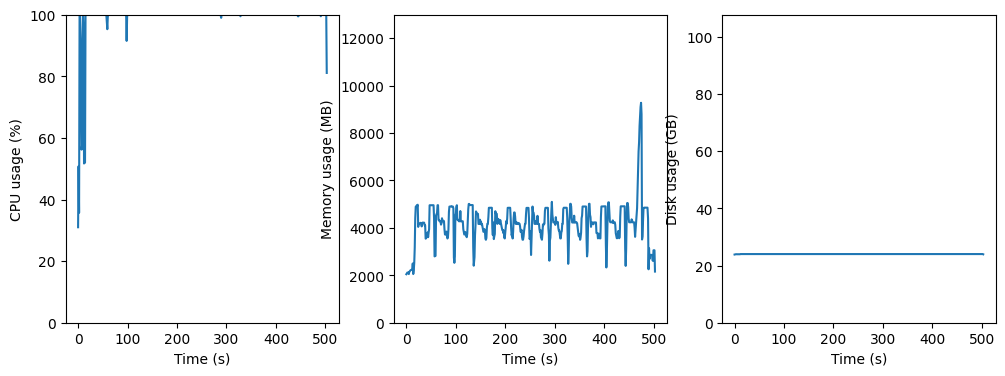

Processing series: 1.2.840.113654.2.55.185309182591805634517860395342326800332
Copying files from IDC buckets..
Done in 0.809778 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 158 DICOM file(s)
Convert 158 DICOM as //content/dcm2niix/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332_1_OPA_GE_LSQX_STANDARD_360_2.5_120_48_0_1.5_20000102000000_2 (512x512x158x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332_1_OPA_GE_LSQX_STANDARD_360_2.5_120_48_0_1.5_20000102000000_2.nii"
Conversion required 8.591694 seconds (0.330693 for core code).
Decoding file /content/Inference/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332.nii 
/content/Inference/1 : decoded 41430464 bytes 
Done i

 39%|███▉      | 31/80 [05:45<14:22, 17.61s/it]

100%|██████████| 80/80 [13:00<00:00,  9.75s/it]

Radiomics Features Calculation Done in 783.039 seconds.


Compressed 117553168 bytes into 886919 bytes ==> 0.75%
Compressed 117472 bytes into 34039 bytes ==> 28.98%


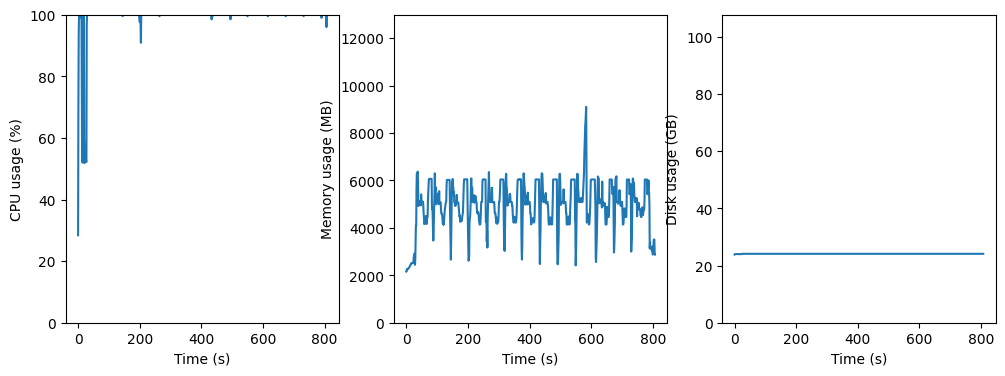

Processing series: 1.2.840.113654.2.55.22770087029972268579113866309746562015
Copying files from IDC buckets..
Done in 1.41389 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 128 DICOM file(s)
Convert 128 DICOM as //content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2 (512x512x128x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015_1_OPA_GE_HSQX_STANDARD_380_2.5_120_56_0.1_1.5_20000102000000_2.nii"
Conversion required 3.591455 seconds (0.274337 for core code).
Decoding file /content/Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.nii 
/content/Inference/1 : decoded 33566144 bytes 
Done in 8.

100%|██████████| 76/76 [09:30<00:00,  7.51s/it]

Radiomics Features Calculation Done in 572.889 seconds.
Compressed 82700118 bytes into 702293 bytes ==> 0.85%


Compressed 106527 bytes into 31420 bytes ==> 29.49%


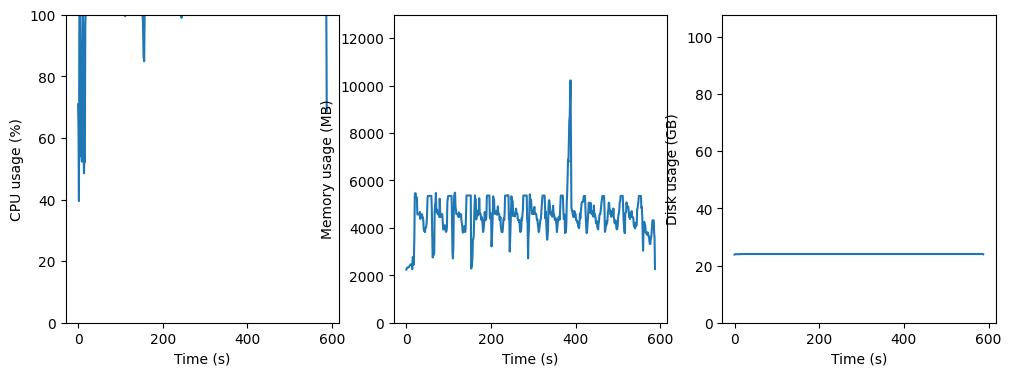

Processing series: 1.2.840.113654.2.55.113040386178547843571271236478024341696
Copying files from IDC buckets..
Done in 1.21043 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 191 DICOM file(s)
Convert 191 DICOM as //content/dcm2niix/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696_0_OPA_GE_LSQX_STANDARD_352_2.5_120_64_0.1_1.5_19990102000000_2 (512x512x191x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696_0_OPA_GE_LSQX_STANDARD_352_2.5_120_64_0.1_1.5_19990102000000_2.nii"
Conversion required 6.330170 seconds (0.449214 for core code).
Decoding file /content/Inference/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696.nii 
/content/Inference/1 : decoded 50081216 bytes 
Don

100%|██████████| 77/77 [14:31<00:00, 11.32s/it]


Radiomics Features Calculation Done in 874.894 seconds.
Compressed 136901370 bytes into 1027310 bytes ==> 0.75%
Compressed 107988 bytes into 31743 bytes ==> 29.39%


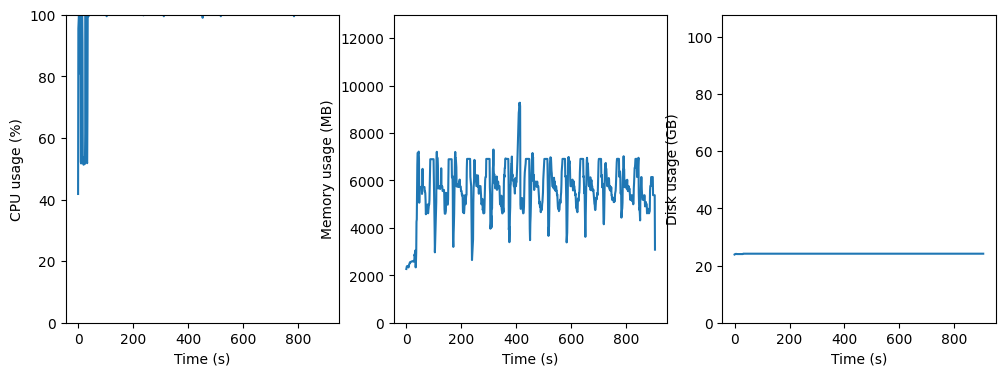

Processing series: 1.2.840.113654.2.55.243990451406006403331425809632881193215
Copying files from IDC buckets..
Done in 0.815168 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 180 DICOM file(s)
Convert 180 DICOM as //content/dcm2niix/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215_1_OPA_GE_LSQX_STANDARD_360_2.5_120_64_0.1_1.5_20000102000000_2 (512x512x180x1)
compress: "/usr/bin/pigz" -n -f -6 "//content/dcm2niix/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215_1_OPA_GE_LSQX_STANDARD_360_2.5_120_64_0.1_1.5_20000102000000_2.nii"
Conversion required 5.288094 seconds (0.416715 for core code).
Decoding file /content/Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215.nii 
/content/Inference/1 : decoded 47197632 bytes 
Do

100%|██████████| 77/77 [13:46<00:00, 10.73s/it]


Radiomics Features Calculation Done in 829.551 seconds.
Compressed 123668136 bytes into 953068 bytes ==> 0.77%
Compressed 107871 bytes into 31927 bytes ==> 29.60%


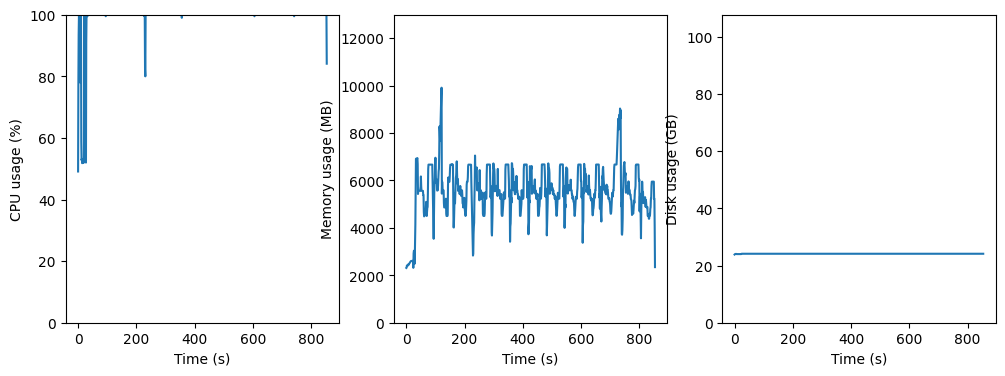

In [29]:

runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','itkimage2segimage_time','radiomics_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'Inference'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(itkimage2segimageAndRadiomics, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total    

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [30]:
start_time = time.time()
try:
  os.remove(f'{curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4')
  os.remove(f'{curr_dir}/pyradiomicsRadiomicsFeatures.tar.lz4')
except OSError:
  pass
!tar cvf - {curr_dir}/itkimage2segimage | lz4 > {curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4
!tar cvf - {curr_dir}/radiomics | lz4 > {curr_dir}/pyradiomicsRadiomicsFeatures.tar.lz4

output_archiving_time = time.time() - start_time

tar: Removing leading `/' from member names
/content/itkimage2segimage/
/content/itkimage2segimage/1.2.840.113654.2.55.100875189782210690344207306235124901243/
/content/itkimage2segimage/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243.dcm.lz4
/content/itkimage2segimage/1.2.840.113654.2.55.14382674871619950799472325766084940706/
/content/itkimage2segimage/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706.dcm.lz4
/content/itkimage2segimage/1.2.840.113654.2.55.216614002338888733987350522981366678482/
/content/itkimage2segimage/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482.dcm.lz4
/content/itkimage2segimage/1.2.840.113654.2.55.146601594654322994982630019583270053397/
/content/itkimage2segimage/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.1466015

###Utilization Metrics

In [31]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_archiving_time']=output_archiving_time
try:
  os.remove('itkimage2segimageUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv itkimage2segimageUsageMetrics.lz4
runtime_stats

Compressed 272835 bytes into 46966 bytes ==> 17.21%


,SeriesInstanceUID,itkimage2segimage_time,radiomics_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total,output_archiving_time
0,1.2.840.113654.2.55.10087518978221069034420730...,8.640480,655.430916,0.210091,"[[[69.5, 90.0, 97.5, 100.0, 100.0, 100.0, 100....","[[[1452.51953125, 1505.1953125, 1541.484375, 1...",[12985.5390625],"[[[23.84477996826172, 23.882911682128906, 23.9...",107.715084,0.223213
1,1.2.840.113654.2.55.14382674871619950799472325...,7.054529,558.880787,0.210786,"[[[26.1, 72.6, 100.0, 100.0, 100.0, 100.0, 72....","[[[1748.4296875, 1769.46484375, 1832.62109375,...",[12985.5390625],"[[[23.844772338867188, 23.904830932617188, 23....",107.715084,0.223213
2,1.2.840.113654.2.55.21661400233888873398735052...,9.350716,601.541246,0.214850,"[[[27.5, 67.2, 100.0, 100.0, 100.0, 71.6, 100....","[[[1822.9140625, 1914.37890625, 1915.6640625, ...",[12985.5390625],"[[[23.844703674316406, 23.971263885498047, 23....",107.715084,0.223213
3,1.2.840.113654.2.55.14660159465432299498263001...,10.353421,636.968581,0.215581,"[[[35.3, 65.5, 93.6, 100.0, 100.0, 100.0, 72.9...","[[[1911.40234375, 1927.00390625, 1999.22265625...",[12985.5390625],"[[[23.84459686279297, 23.913021087646484, 23.9...",107.715084,0.223213
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401...,7.140091,505.438470,0.209937,"[[[24.6, 58.7, 94.5, 100.0, 100.0, 100.0, 100....","[[[2033.03515625, 2056.41015625, 2139.0625, 21...",[12985.5390625],"[[[23.844635009765625, 23.901248931884766, 23....",107.715084,0.223213
5,1.2.840.113654.2.55.15480970559124215907525360...,6.931211,490.376858,0.209913,"[[[31.0, 50.8, 35.7, 100.0, 100.0, 91.5, 71.5,...","[[[2045.13671875, 2070.41015625, 2114.3203125,...",[12985.5390625],"[[[23.844593048095703, 23.89134979248047, 23.9...",107.715084,0.223213
6,1.2.840.113654.2.55.18530918259180563451786039...,14.374402,783.038838,0.311104,"[[[28.4, 69.7, 93.0, 100.0, 100.0, 100.0, 100....","[[[2156.796875, 2163.78515625, 2270.3828125, 2...",[12985.5390625],"[[[23.844417572021484, 23.922195434570312, 24....",107.715084,0.223213
7,1.2.840.113654.2.55.22770087029972268579113866...,8.638620,572.888597,0.210770,"[[[70.9, 63.1, 39.5, 100.0, 100.0, 100.0, 77.4...","[[[2236.8671875, 2278.32421875, 2324.86328125,...",[12985.5390625],"[[[23.844345092773438, 23.90636444091797, 23.9...",107.715084,0.223213
8,1.2.840.113654.2.55.11304038617854784357127123...,22.416031,874.894481,0.314242,"[[[41.8, 95.5, 98.0, 100.0, 100.0, 100.0, 100....","[[[2264.859375, 2336.78515625, 2381.1796875, 2...",[12985.5390625],"[[[23.844268798828125, 23.88583755493164, 24.0...",107.715084,0.223213
9,1.2.840.113654.2.55.24399045140600640333142580...,17.689974,829.550524,0.313329,"[[[49.1, 77.3, 93.5, 100.0, 100.0, 100.0, 100....","[[[2309.34765625, 2320.93359375, 2414.53125, 2...",[12985.5390625],"[[[23.844310760498047, 23.932918548583984, 24....",107.715084,0.223213
